In [22]:
from profiler.discontinuity import detect_discontinuities
from pathlib import Path
from pyvideosync.data_pool import VideoFilesPool
from pyvideosync.videojson import Videojson
from pyvideosync.nev import Nev
from pyvideosync.video import Video
from pyvideosync.nsx import Nsx
import json
import os
from pyvideosync.utils import is_incrementally_increasing, to_16bit_binary, fill_missing_data, frame2min
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
json_1_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_083441.json"
video_1_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_083441.23512011.mp4"
json_2_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_085441.json"
video_2_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_085441.23512011.mp4"
nev_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.nev"
ns5_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.ns5"

In [3]:
camera_serial = "23512011"

In [4]:
output_dir = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files"

1. discontinuties in chunk serial in JSON

In [8]:
def save_discontinuities_to_json(json_1_path, json_2_path, camera_serial, output_dir):
    for json_path in [json_1_path, json_2_path]:
        videojson = Videojson(json_path)
        chunk_serials = videojson.get_chunk_serial_list(camera_serial)
        frame_ids = videojson.get_frame_ids_list(camera_serial)

        chunk_discontinuities = detect_discontinuities(chunk_serials)
        frame_discontinuities = detect_discontinuities(frame_ids)

        # Prepare data for saving
        discontinuities_data = {
            'chunk_discontinuities': chunk_discontinuities,
            'frame_discontinuities': frame_discontinuities
        }

        # Create output file name based on input json file
        json_filename = os.path.basename(json_path)
        output_filename = f"{os.path.splitext(json_filename)[0]}_{camera_serial}_discontinuities.json"
        save_path = os.path.join(output_dir, output_filename)

        # Save to JSON
        with open(save_path, 'w') as f:
            json.dump(discontinuities_data, f, indent=4)

        print(f"Saved discontinuities to {save_path}")

In [11]:
save_discontinuities_to_json(json_1_path, json_2_path, camera_serial, output_dir)

Saved discontinuities to /home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/utsw_TRD011_day_2_20240717_083441_23512011_discontinuities.json
Saved discontinuities to /home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/utsw_TRD011_day_2_20240717_085441_23512011_discontinuities.json


2. Is my current get_camera_df() function able to interpolate those discontinuities such that the resulting dataframe doesn't have any discontinuties any more?

In [5]:
def save_camera_discontinuities(json_1_path, json_2_path, camera_serial, output_dir):
    for json_path in [json_1_path, json_2_path]:
        videojson = Videojson(json_path)
        camera_df = videojson.get_camera_df(camera_serial)

        chunk_serial = camera_df["chunk_serial_data"].to_numpy()
        frame_id_reconstructed = camera_df["frame_ids_reconstructed"].to_numpy()

        # Check incremental continuity and log results
        chunk_serial_incremental = is_incrementally_increasing(chunk_serial)
        frame_id_incremental = is_incrementally_increasing(frame_id_reconstructed)

        print(f"{json_path} ({camera_serial}) - chunk_serial_data incremental? {chunk_serial_incremental}")
        print(f"{json_path} ({camera_serial}) - frame_ids_reconstructed incremental? {frame_id_incremental}")
        
        chunk_discontinuities = detect_discontinuities(chunk_serial)
        frame_discontinuities = detect_discontinuities(frame_id_reconstructed)

        discontinuities_data = {
            'chunk_discontinuities': chunk_discontinuities,
            'frame_discontinuities': frame_discontinuities
        }

        # Generate a descriptive save path
        base_filename = os.path.splitext(os.path.basename(json_path))[0]
        save_filename = f"{base_filename}_{camera_serial}_discontinuities_camera_df.json"
        save_path = os.path.join(output_dir, save_filename)

        with open(save_path, 'w') as f:
            json.dump(discontinuities_data, f, indent=4)

        print(f"Discontinuities data saved to {save_path}")

        # Save camera DataFrame to CSV
        csv_save_filename = f"{base_filename}_{camera_serial}_camera_df.csv"
        csv_save_path = os.path.join(output_dir, csv_save_filename)
        camera_df.to_csv(csv_save_path, index=False)
        print(f"Camera DataFrame saved to {csv_save_path}")

In [6]:
save_camera_discontinuities(json_1_path, json_2_path, camera_serial, output_dir)

/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_083441.json (23512011) - chunk_serial_data incremental? True
/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_083441.json (23512011) - frame_ids_reconstructed incremental? True
Discontinuities data saved to /home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/utsw_TRD011_day_2_20240717_083441_23512011_discontinuities_camera_df.json
Camera DataFrame saved to /home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/utsw_TRD011_day_2_20240717_083441_23512011_camera_df.csv
/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_085441.json (23512011) - chunk_serial_data incremental? True
/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/source-files/utsw_TRD011_day_2_20240717_085441.json (23512011) - frame_ids_reconstructed incremental? True
Discontinuities d

3. It seems like 085441 JSON has more problems and the code itself can't fix it all, let's do a deep dive into it

In [5]:
csv_path = "/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/utsw_TRD011_day_2_20240717_085441_23512011_camera_df.csv"

In [13]:
camera_df_2 = pd.read_csv(csv_path)
camera_df_2

,chunk_serial_data,frame_id,frame_ids_reconstructed
0,2811817,19396,19396
1,2811818,19397,19397
2,2811819,19398,19398
3,2811820,19399,19399
4,2811821,19400,19400
...,...,...,...
35995,2852501,60080,60080
35996,2852502,60081,60081
35997,2852503,60082,60082
35998,2852504,60083,60083


In [5]:
nev = Nev(nev_path)
nev_chunk_serial_df = nev.get_chunk_serial_df()
nev_chunk_serial_df


EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.nev opened

EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.nev closed


,TimeStamps,chunk_serial,UTCTimeStamp
0,4057455854,2798706,2024-07-19 01:29:47.198467
1,4057456855,2798707,2024-07-19 01:29:47.231833
2,4057457856,2798708,2024-07-19 01:29:47.265200
3,4057458856,2798709,2024-07-19 01:29:47.298533
4,4057459857,2798710,2024-07-19 01:29:47.331900
...,...,...,...
38299,4095782941,2837005,2024-07-19 01:51:04.768033
38300,4095783942,2837006,2024-07-19 01:51:04.801400
38301,4095784943,2837007,2024-07-19 01:51:04.834767
38302,4095785943,2837008,2024-07-19 01:51:04.868100


In [10]:
nev = Nev(nev_path)
nev_digital_events_df = nev.get_digital_events_df()
nev_digital_events_df.head(20)


EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.nev opened

EMU-0222_subj-DBSTRD011_task-Conversations_date-20240717_time-084723.nev closed


,InsertionReason,TimeStamps,UnparsedData
0,1,4057455301,60414
1,1,4057455853,60415
2,129,4057455854,114
3,129,4057455857,104
4,129,4057455860,42
5,129,4057455863,1
6,129,4057455866,0
7,1,4057456302,60414
8,1,4057456854,60415
9,129,4057456855,115


In [24]:
nev.get_basic_header()

{'FileTypeID': 'BREVENTS',
 'FileSpec': '3.0',
 'AddFlags': 1,
 'BytesInHeader': 26512,
 'BytesInDataPackets': 108,
 'TimeStampResolution': 30000,
 'SampleTimeResolution': 30000,
 'TimeOrigin': datetime.datetime(2024, 7, 17, 11, 55, 38, 670000),
 'CreatingApplication': 'File Dialog v7.6.1',
 'Comment': '',
 'NumExtendedHeaders': 818}

In [16]:
nev_digital_events_df_small = nev_digital_events_df.iloc[:20]
nev_digital_events_df_small.to_csv("/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/digital_events_df_first_20_rows.csv", index=False)

In [10]:
nev_cleaned_digital_events_df = nev.get_cleaned_digital_events_df()
nev_cleaned_digital_events_df.to_csv("/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/cleaned_digital_events_df.csv")

In [17]:
nev_chunk_serial_df.to_csv("/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/nev_chunk_serial_df.csv")

In [35]:
chunk_serial = nev_chunk_serial_df["chunk_serial"].to_numpy()
chunk_discontinuities = detect_discontinuities(chunk_serial)
chunk_discontinuities

{'type_i': {'count': 0, 'gaps': []},
 'type_ii': {'count': 0, 'gaps': []},
 'type_iii': {'count': 0, 'gaps': [], 'differences': {}},
 'type_iv': {'count': 0, 'gaps': []}}

In [36]:
is_incrementally_increasing(chunk_serial)

True

In [22]:
video = Video(video_1_path)
video.get_frame_count()

36000

Let's also check timestamps (in nanoseconds)

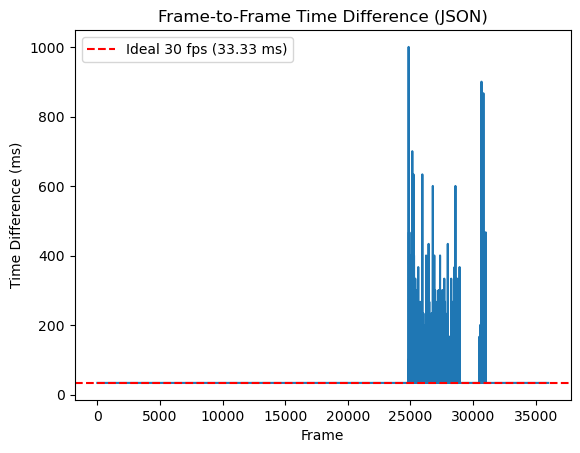

In [29]:
with open(json_2_path, "r") as f:
    dic_2 = json.load(f)

timestamps = np.array(dic_2["timestamps"])
time_diff = np.diff(timestamps.flatten()) / 1e6  # milliseconds per frame

plt.plot(time_diff)
plt.axhline(33.33, color='r', linestyle='--', label='Ideal 30 fps (33.33 ms)')
plt.xlabel('Frame')
plt.ylabel('Time Difference (ms)')
plt.title('Frame-to-Frame Time Difference (JSON)')
plt.legend()
plt.show()


How much exactly is the time difference between trigger and serial?

In [13]:
def plot_cam_exposure_all(
    digital_events_df,
    save_path: str = None,
    start: int = 0,
    end: int = 1000,
    bit: int = 0,
) -> None:
    """
    Plots camera exposure (trigger signals) alongside reconstructed serial data,
    aligning both datasets by timestamps.

    Args:
        digital_events_df (pd.DataFrame): NEV digital events dataframe filtered with `InsertionReason==1`,
            containing timestamped trigger signals.
        nev_chunk_serial_df (pd.DataFrame): DataFrame with reconstructed serial data (`chunk_serial` vs. `TimeStamps`).
        save_path (str, optional): File path to save the plot. If None, the plot is displayed.
        start (int, optional): Starting index for slicing the dataset for visualization.
        end (int, optional): Ending index for slicing the dataset for visualization.
        bit (int, optional): Bit number corresponding to the trigger signal.

    Returns:
        None. Displays or saves the plot.

    Example:
        >>> plot_cam_exposure_all(
                digital_events_df=df1,
                nev_chunk_serial_df=df2,
                save_path="output.png",
                start=0,
                end=1000,
                bit=0
            )
    """

    # Only keep events with InsertionReason == 1
    digital_events_df_trigger = digital_events_df[digital_events_df["InsertionReason"] == 1]

    # get a subset of digital events df if first_n_rows is specified
    if start is not None and end is not None:
        digital_events_df_small = digital_events_df_trigger.iloc[start:end].copy()
    else:
        digital_events_df_small = digital_events_df_trigger.copy()

    # Format UnparsedData to 16-bit
    digital_events_df_small.loc[:, "UnparsedDataBin"] = digital_events_df_small[
        "UnparsedData"
    ].apply(lambda x: to_16bit_binary(x))
    filled_df = fill_missing_data(digital_events_df_small, bit_number=bit)
    
    # Select relevant columns for merging
    filled_df = filled_df[["TimeStamps", f"Bit{bit}"]]
    insertion_129 = digital_events_df[digital_events_df["InsertionReason"] == 129]
    nev_chunk_serial_df = insertion_129[["TimeStamps", "UnparsedData"]]

    print(nev_chunk_serial_df)
    
    # Merge both dataframes using an outer join to align timestamps
    merged_df = pd.merge(filled_df, nev_chunk_serial_df, on="TimeStamps", how="left")
    
    # Set up stacked subplots sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Plot Trigger signal (upper plot)
    ax1.step(
        merged_df["TimeStamps"],
        merged_df[f"Bit{bit}"],
        where="post",
        label=f"Trigger (Bit {bit})",
        linewidth=1.5,
        color="blue"
    )
    ax1.set_ylabel(f"Trigger Bit {bit}")
    ax1.set_title("Camera Exposure / Trigger Signal")
    ax1.grid(True)
    ax1.legend(loc="upper right")

    # Plot Reconstructed Serial Data (lower plot)
    ax2.plot(
        merged_df["TimeStamps"],
        merged_df["UnparsedData"],
        marker='o',
        markersize=3,
        linestyle='-',
        linewidth=1.5,
        color="red",
        label="Reconstructed Serial"
    )
    ax2.set_ylabel("UnparsedData Number")
    ax2.set_title("UnparsedData")
    ax2.grid(True)
    ax2.legend(loc="upper right")

    # Common x-axis label
    ax2.set_xlabel("Time (seconds)")

    plt.tight_layout()

    # Save or show plot
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

In [7]:
nev_chunk_serial_df

,TimeStamps,chunk_serial,UTCTimeStamp
0,4057455854,2798706,2024-07-19 01:29:47.198467
1,4057456855,2798707,2024-07-19 01:29:47.231833
2,4057457856,2798708,2024-07-19 01:29:47.265200
3,4057458856,2798709,2024-07-19 01:29:47.298533
4,4057459857,2798710,2024-07-19 01:29:47.331900
...,...,...,...
38299,4095782941,2837005,2024-07-19 01:51:04.768033
38300,4095783942,2837006,2024-07-19 01:51:04.801400
38301,4095784943,2837007,2024-07-19 01:51:04.834767
38302,4095785943,2837008,2024-07-19 01:51:04.868100


        TimeStamps  UnparsedData
2       4057455854           114
3       4057455857           104
4       4057455860            42
5       4057455863             1
6       4057455866             0
...            ...           ...
268123  4095786944            17
268124  4095786947            20
268125  4095786950            45
268126  4095786953             1
268127  4095786956             0

[191520 rows x 2 columns]


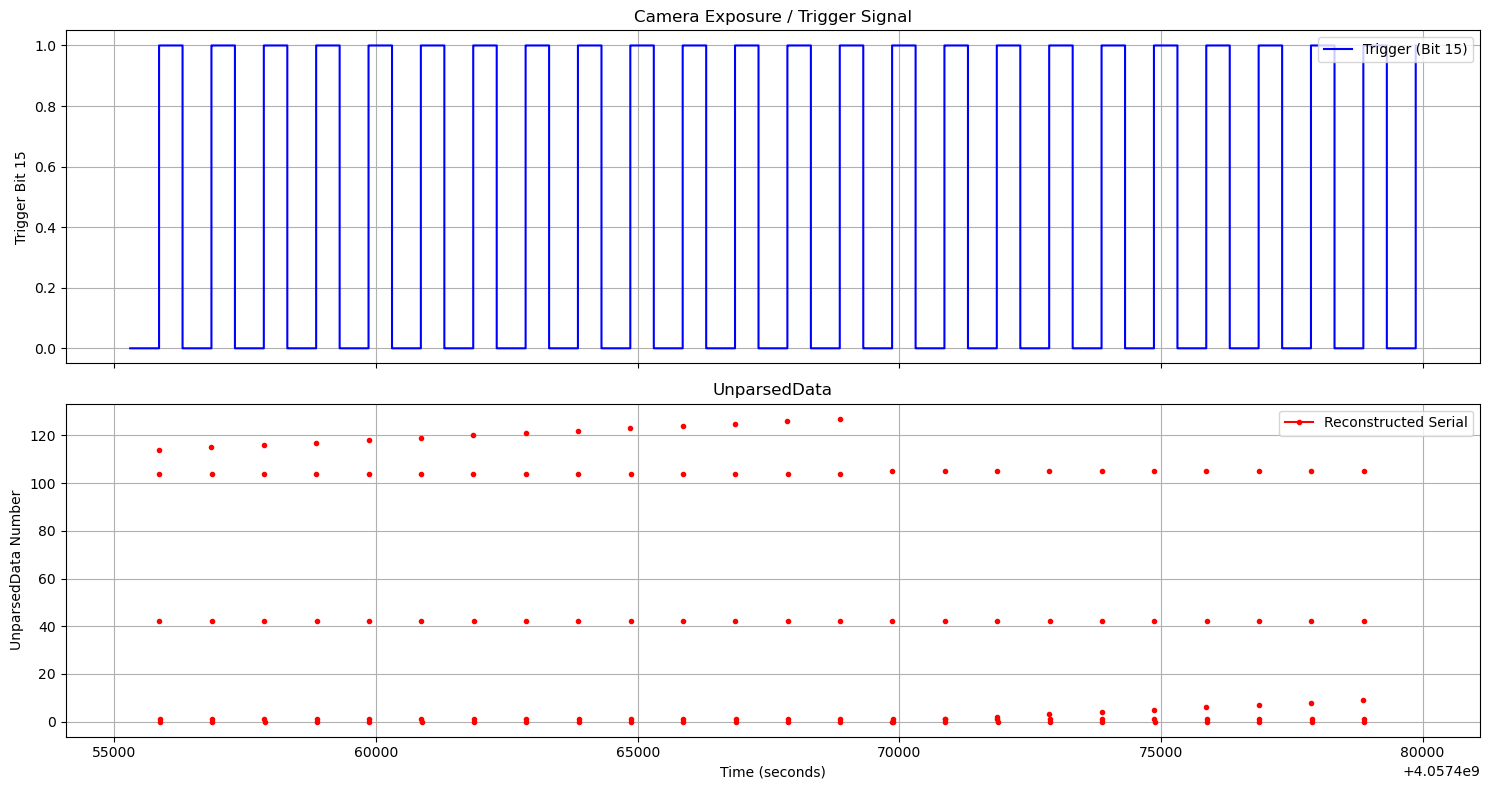

In [14]:
plot_cam_exposure_all(
    nev_digital_events_df,
    save_path="./cam_expo2.png",
    start= 0,
    end=50,
    bit=15,
)

In [25]:
nev.plot_cam_exposure_all(
    save_path=
)

TypeError: Nev.plot_cam_exposure_all() missing 3 required positional arguments: 'save_path', 'start', and 'end'

What's the length of each trigger rising edge?

In [28]:
trigger = pd.read_csv("/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/merged_raw.csv")
trigger

,Unnamed: 0,TimeStamps,Bit15,UnparsedData
0,0,4057455301,0,NaN
1,1,4057455302,0,NaN
2,2,4057455303,0,NaN
3,3,4057455304,0,NaN
4,4,4057455305,0,NaN
...,...,...,...,...
24564,24564,4057479865,0,NaN
24565,24565,4057479866,0,NaN
24566,24566,4057479867,0,NaN
24567,24567,4057479868,0,NaN


In [29]:
def find_one_durations(arr):
    # Identify where the array changes
    diff = np.diff(np.concatenate(([0], arr, [0])))  # Add 0 at start and end to capture edges
    start_indices = np.where(diff == 1)[0]  # Indices where 1 starts
    end_indices = np.where(diff == -1)[0]   # Indices where 1 ends
    
    # Compute the durations of 1s
    durations = end_indices - start_indices
    
    return durations

In [30]:
find_one_durations(trigger["Bit15"].to_numpy())

array([449, 449, 449, 449, 449, 449, 449, 449, 450, 449, 449, 449, 449,
       449, 449, 450, 449, 449, 449, 449, 449, 449, 450, 449,   1])

How many frames are there exactly for the videos??

In [32]:
import subprocess

def count_frames_ffmpeg(video_path: str) -> int:
    cmd = [
        "ffprobe", "-v", "error", "-select_streams", "v:0",
        "-count_packets", "-show_entries", "stream=nb_read_packets",
        "-of", "csv=p=0", video_path
    ]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return int(result.stdout.strip())

In [33]:
frame_count = count_frames_ffmpeg(video_1_path)
print(f"Total frames: {frame_count}")

Total frames: 36000


In [5]:
frame_count = count_frames_ffmpeg(video_2_path)
print(f"Total frames: {frame_count}")

NameError: name 'count_frames_ffmpeg' is not defined

Noticed that the audio has longer length than the video, what's going on?

In [6]:
all_merged = pd.read_csv("/home/auto/CODE/utils/video-sync/Testing/TRD011/EMU-0222/intermediate-files/all_merged.csv")
all_merged

,Unnamed: 0,TimeStamp,Amplitude,chunk_serial,frame_ids_reconstructed,frame_ids_relative,mp4_file
0,0,4057455854,-49,2798706.0,71820.0,22890.0,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
1,1,4057455855,-20,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
2,2,4057455856,-50,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
3,3,4057455857,-97,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
4,4,4057455858,-127,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
...,...,...,...,...,...,...,...
38330086,38330086,4095786940,13,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330087,38330087,4095786941,61,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330088,38330088,4095786942,57,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330089,38330089,4095786943,72,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...


In [10]:
for mp4_path in all_merged["mp4_file"].unique():
    df_sub = all_merged[all_merged["mp4_file"] == mp4_path]
    print(is_incrementally_increasing(df_sub["TimeStamp"]))

True
True


In [12]:
mp4_file_path = all_merged.iloc[0]["mp4_file"]
first_sub = all_merged[all_merged["mp4_file"] == mp4_file_path]
first_sub

,Unnamed: 0,TimeStamp,Amplitude,chunk_serial,frame_ids_reconstructed,frame_ids_relative,mp4_file
0,0,4057455854,-49,2798706.0,71820.0,22890.0,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
1,1,4057455855,-20,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
2,2,4057455856,-50,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
3,3,4057455857,-97,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
4,4,4057455858,-127,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
...,...,...,...,...,...,...,...
13119594,13119594,4070575448,-36,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119595,13119595,4070575449,-59,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119596,13119596,4070575450,-26,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119597,13119597,4070575451,-39,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...


In [23]:
# let's do some calculation
audio_duration_s = len(first_sub) / 30000
print(audio_duration_s)
print(frame2min(len(first_sub), 30000))

437.3199666666667
07:17


In [28]:
video_duration_s = (36000 - 22890 + 1) / 30
print(video_duration_s)
print(frame2min((36000 - 22890 + 1), 30))

437.03333333333336
07:17


In [20]:
mp4_file_path = all_merged.iloc[-1]["mp4_file"]
second_sub = all_merged[all_merged["mp4_file"] == mp4_file_path]
second_sub

,Unnamed: 0,TimeStamp,Amplitude,chunk_serial,frame_ids_reconstructed,frame_ids_relative,mp4_file
13119599,13119599,4070576453,-90,2811817.0,19396.0,1.0,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119600,13119600,4070576454,-109,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119601,13119601,4070576455,-117,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119602,13119602,4070576456,-93,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
13119603,13119603,4070576457,-79,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
...,...,...,...,...,...,...,...
38330086,38330086,4095786940,13,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330087,38330087,4095786941,61,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330088,38330088,4095786942,57,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...
38330089,38330089,4095786943,72,NaN,NaN,NaN,/mnt/datalake/data/TRD-43036/DBSTRD011/CAMERA/...


In [25]:
# let's do some calculation
audio_duration_s = len(second_sub) / 30000
print(audio_duration_s)
print(frame2min(len(second_sub), 30000))

840.3497333333333
14:00


In [27]:
video_duration_s = (25193 - 1 + 1) / 30
print(video_duration_s)
print(frame2min((25193 - 1 + 1), 30))

839.7666666666667
13:59
